<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/LSTM_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

In [3]:
!pip install nltk scikit-learn matplotlib

In [6]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
with open("/content/DeteksiSarkasme.json", "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower()

texts = df['headline'].astype(str).apply(clean_text).tolist()
labels = df['is_sarcastic'].values

tokenized = [word_tokenize(t) for t in texts]
all_words = [word for tokens in tokenized for word in tokens]
vocab = ['<PAD>', '<UNK>'] + [w for w, _ in Counter(all_words).most_common(10000)]
word2idx = {word: idx for idx, word in enumerate(vocab)}

def encode(text, max_len=40):
    tokens = word_tokenize(text)
    encoded = [word2idx.get(w, word2idx['<UNK>']) for w in tokens][:max_len]
    return encoded + [0] * (max_len - len(encoded))

encoded_texts = [encode(t) for t in texts]
X = torch.tensor(encoded_texts)
y = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SarcasmDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(SarcasmDataset(X_test, y_test), batch_size=64)


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        return self.sigmoid(out).squeeze()


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size=len(vocab), embed_dim=64, hidden_dim=256).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, train_accuracies = [], []

for epoch in range(15):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == y_batch.int()).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {acc:.4f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(acc)


Epoch 1 | Loss: 174.4502 | Accuracy: 0.7249
Epoch 2 | Loss: 131.5993 | Accuracy: 0.8178
Epoch 3 | Loss: 103.4440 | Accuracy: 0.8644
Epoch 4 | Loss: 80.7091 | Accuracy: 0.8995
Epoch 5 | Loss: 69.8415 | Accuracy: 0.9182
Epoch 6 | Loss: 43.7894 | Accuracy: 0.9519
Epoch 7 | Loss: 28.0288 | Accuracy: 0.9705
Epoch 8 | Loss: 17.5316 | Accuracy: 0.9828
Epoch 9 | Loss: 12.1445 | Accuracy: 0.9882
Epoch 10 | Loss: 7.8272 | Accuracy: 0.9925
Epoch 11 | Loss: 5.5052 | Accuracy: 0.9947
Epoch 12 | Loss: 6.4707 | Accuracy: 0.9938
Epoch 13 | Loss: 5.5945 | Accuracy: 0.9952
Epoch 14 | Loss: 4.3696 | Accuracy: 0.9957
Epoch 15 | Loss: 4.4199 | Accuracy: 0.9955


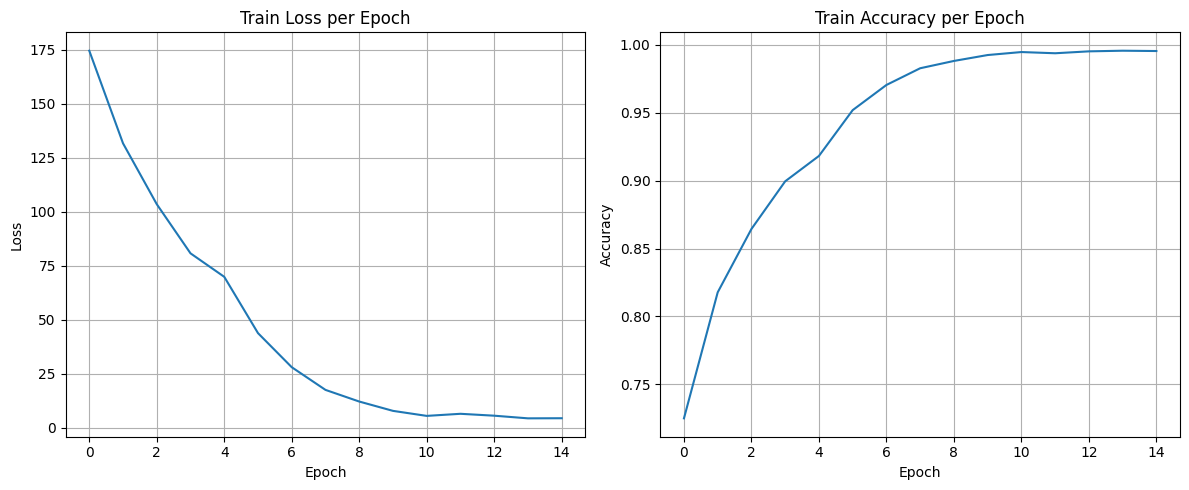

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Loss")
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Accuracy")
plt.title("Train Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()


In [18]:
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = outputs.cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

acc = accuracy_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds)
rec = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)

print("=== Evaluation on Test Set ===")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


=== Evaluation on Test Set ===
Akurasi  : 0.8506
Presisi  : 0.8354
Recall   : 0.8218
F1-Score : 0.8285
AUC      : 0.9278


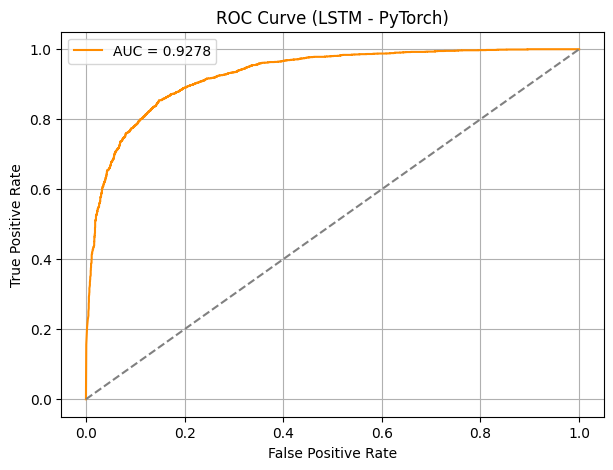

In [19]:
fpr, tpr, _ = roc_curve(all_targets, all_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve (LSTM - PyTorch)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


#Tensorflow Hyperparameter Tunning

In [21]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [22]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [23]:
data = []
with open("/content/DeteksiSarkasme.json", "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
texts = df['headline'].astype(str).values
labels = df['is_sarcastic'].values

def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower()

texts = [clean_text(t) for t in texts]

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=40)

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [26]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Choice('embedding_dim', [32, 64, 128]),
        input_length=40
    ))
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=64, max_value=256, step=32),
        return_sequences=False
    ))
    model.add(Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])

    # Fix: Create the optimizer instance with the learning rate
    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)


    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [27]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results_lstm',
    project_name='sarcasm_lstm'
)

tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"LSTM Units     : {best_hps.get('lstm_units')}")
print(f"Embedding Dim  : {best_hps.get('embedding_dim')}")
print(f"Optimizer      : {best_hps.get('optimizer')}")
print(f"Learning Rate  : {best_hps.get('learning_rate')}")


Trial 5 Complete [00h 06m 55s]
val_accuracy: 0.8467477560043335

Best val_accuracy So Far: 0.8467477560043335
Total elapsed time: 00h 27m 50s
Best Hyperparameters:
LSTM Units     : 256
Embedding Dim  : 128
Optimizer      : adam
Learning Rate  : 0.0001


In [28]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.5589 - loss: 0.6860 - val_accuracy: 0.5538 - val_loss: 0.6864
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 80s 263ms/step - accuracy: 0.7306 - loss: 0.5075 - val_accuracy: 0.8423 - val_loss: 0.3624
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 88s 286ms/step - accuracy: 0.8991 - loss: 0.2572 - val_accuracy: 0.8507 - val_loss: 0.3526
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 72s 267ms/step - accuracy: 0.9323 - loss: 0.1853 - val_accuracy: 0.8458 - val_loss: 0.4067
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.9535 - loss: 0.1376 - val_accuracy: 0.8423 - val_loss: 0.4290


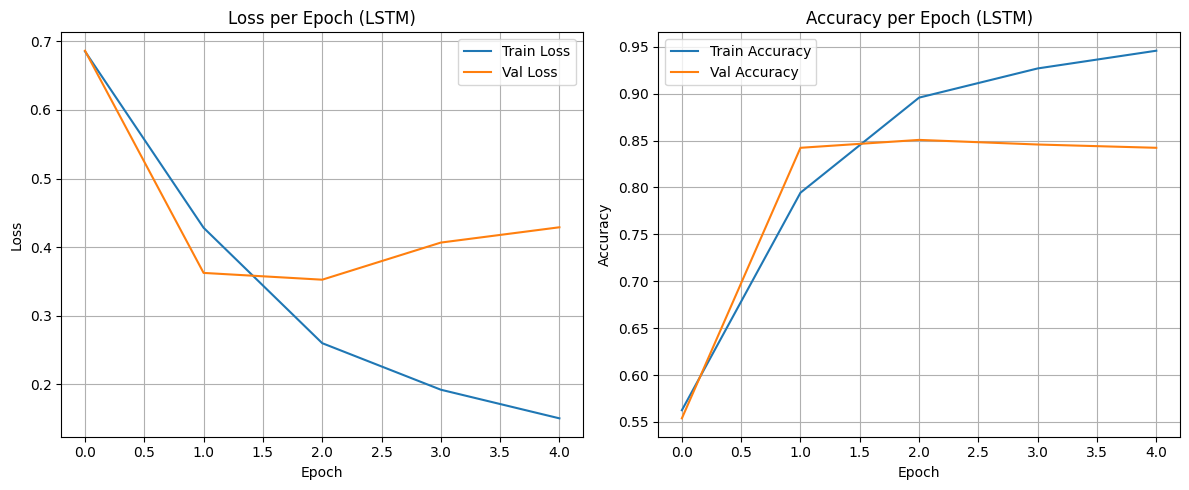

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss per Epoch (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy per Epoch (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
=== Final Evaluation (LSTM) ===
Akurasi  : 0.8480
Presisi  : 0.8587
Recall   : 0.7826
F1-Score : 0.8189
AUC      : 0.9297


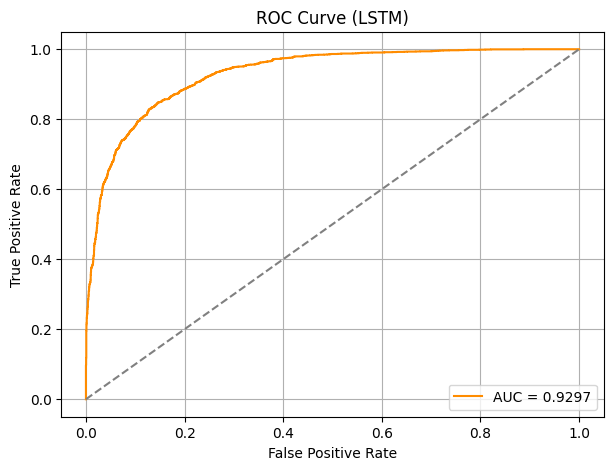

In [30]:
y_probs = best_model.predict(X_test).flatten()
y_preds = (y_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
auc = roc_auc_score(y_test, y_probs)

print("=== Final Evaluation (LSTM) ===")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LSTM)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
